#### In the below, we are going to optimize our model, having arrived on feature set 7 in the previous notebook. 

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [64]:
df_model7 = pd.read_csv('df_model7.csv')

In [65]:
df_model7.head()

,Unnamed: 0,Half Bath,Bsmt Full Bath,Wood Deck SF,BsmtFin SF 1,Fireplaces,Mas Vnr Area,Full Bath,Year Remod/Add,Year Built,...,Stone_ext_1st,Stucco_ext_1st,VinylSd_ext_1st,Wd Sdng_ext_1st,WdShing_ext_1st,Fa_heat,Gd_heat,Po_heat,TA_heat,Central Air
0,0,1,0.0,0,533.0,0,289.0,2,2005,1976,...,0,0,0,0,0,0,0,0,0,1
1,1,1,1.0,0,637.0,1,132.0,2,1997,1996,...,0,0,1,0,0,0,0,0,0,1
2,2,0,1.0,0,731.0,0,0.0,1,2007,1953,...,0,0,1,0,0,0,0,0,1,1
3,3,1,0.0,100,0.0,0,0.0,2,2007,2006,...,0,0,1,0,0,0,1,0,0,1
4,4,0,0.0,0,0.0,0,0.0,2,1993,1900,...,0,0,0,1,0,0,0,0,1,1


#### As a reminder, the best score was from Ridge. We will now optimize hyperparameters to see if we can improve on that.

In [67]:
X = df_model7.drop(columns = 'SalePrice')
y = df_model7['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)


#### First, let's optimize our Ridge regression by using a range of values for alpha, from 1 to 10^5. We will use cross validation to find the best performing alpha value and select that as our model.

In [68]:
from sklearn.linear_model import RidgeCV
r_alphas = np.logspace(0,5,100)

In [69]:
ridge_model = RidgeCV(alphas=r_alphas, cv=5)
ridge_model = ridge_model.fit(X_train, y_train)

In [70]:
ridge_model.alpha_

5.094138014816379

In [71]:
ridge_model.fit(X_train, y_train)
predictions = ridge_model.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {ridge_model.score(X_train, y_train)}, Test score: {ridge_model.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.9125389831490263, Test score: 0.9033648581090231, RMSE: 22788.41690137969


In [75]:
cv_ridge = cross_val_score (ridge_model, X_train, y_train, cv = 5).mean()
cv_ridge

0.8940327367656368

#### This results in a slight worsening in Ridge's test score. Let's take a similar approach for Lasso.

In [77]:
from sklearn.linear_model import LassoCV
l_alphas = np.logspace(-3, 0, 100) 
lasso_model = LassoCV(alphas=l_alphas, cv=5, max_iter=5000)
lasso_model = lasso_model.fit(X_train, y_train)

In [78]:
lasso_model.alpha_

1.0

In [79]:
lasso_model.fit(X_train, y_train)
predictions = lasso_model.predict(X_train)
rmse = (mean_squared_error(y_train, predictions)**0.5)

print(f'Train score: {lasso_model.score(X_train, y_train)}, Test score: {lasso_model.score(X_test, y_test)}, RMSE: {rmse}')

Train score: 0.9126605098664707, Test score: 0.9024327107877603, RMSE: 22772.579192830086


In [80]:
cv_lasso = cross_val_score (lasso_model, X_train, y_train, cv = 5).mean()
cv_lasso

0.8940466921267584

#### Again, this leads to a slight improvement in the test score for Lasso. On Cross validation of these models, the scores are extremely similar, with Lasso fractionally ahead. So we will use optimised Lasso as our final model.

#### Using this model, let's examine which are the most important features for determining Sale Price. We will build a dataframe of the features and rank by absolute correlation and coefficient.

In [50]:
lasso_model.coef_

array([   170.63449229,   1411.88841314,   1678.52486985,   1219.9397164 ,
         9936.42821588,   3415.90429521,   2374.55942014,   -281.0555395 ,
         5079.23613997,   9538.02491674,   6535.11274681,   2434.95488957,
         4927.75191588,  22689.79155768,  12286.62177124,   -369.05239724,
         -850.50917358,  -5221.2323417 ,  -1151.89447658,  -7622.58468561,
        -1071.02988433,  -7935.86006078,  -6698.72517407,   -181.25812176,
         2949.67512329,  -5726.86056402,      0.        ,  -3074.40272679,
        -5446.73397847, -11286.73322377,    -61.36180774,  -6263.54010628,
         -736.59879146,   2608.0183109 ,  -9540.27663468,  -3389.07749618,
        -6279.09096913,  -6625.85526945,  -2943.9876294 ,   5020.60579503,
        -3284.3635311 ,  -1922.10236157,   1397.80073638,    217.46182076,
          998.3083228 ,   -402.81193039,  -2092.35919896,    354.21990908,
         -551.84079453,   -401.42515921,    109.36720021,  -3599.81168869,
        -9673.80767746,  

In [29]:
lasso_coef_list = []
for i in lasso_model.coef_:
    lasso_coef_list.append(i)

In [30]:
len(lasso_coef_list)

91

In [91]:
df_model7.columns

Index(['Unnamed: 0', 'Half Bath', 'Bsmt Full Bath', 'Wood Deck SF',
       'BsmtFin SF 1', 'Fireplaces', 'Mas Vnr Area', 'Full Bath',
       'Year Remod/Add', 'Year Built', 'Total Bsmt SF', 'Garage Cars',
       'Garage Area', 'Gr Liv Area', 'Overall Qual', 'SalePrice',
       'Blueste_neigh', 'BrDale_neigh', 'BrkSide_neigh', 'ClearCr_neigh',
       'CollgCr_neigh', 'Crawfor_neigh', 'Edwards_neigh', 'Gilbert_neigh',
       'Greens_neigh', 'GrnHill_neigh', 'IDOTRR_neigh', 'Landmrk_neigh',
       'MeadowV_neigh', 'Mitchel_neigh', 'NAmes_neigh', 'NPkVill_neigh',
       'NWAmes_neigh', 'NoRidge_neigh', 'NridgHt_neigh', 'OldTown_neigh',
       'SWISU_neigh', 'Sawyer_neigh', 'SawyerW_neigh', 'Somerst_neigh',
       'StoneBr_neigh', 'Timber_neigh', 'Veenker_neigh', '30_subclass',
       '40_subclass', '45_subclass', '50_subclass', '60_subclass',
       '70_subclass', '75_subclass', '80_subclass', '85_subclass',
       '90_subclass', '120_subclass', '150_subclass', '160_subclass',
       '180_

In [31]:
cols = df_model7.drop(columns = 'SalePrice').columns
len(cols)

91

In [32]:
list_of_tuples = list(zip(cols, lasso_coef_list))
list_of_tuples[:5]

[('Unnamed: 0', 170.63449229224602),
 ('Half Bath', 1411.8884131374416),
 ('Bsmt Full Bath', 1678.5248698503437),
 ('Wood Deck SF', 1219.9397163989436),
 ('BsmtFin SF 1', 9936.428215880132)]

In [89]:
df_coefs_correls = pd.DataFrame(list_of_tuples, columns = ['Feature', 'Coef'])
df_coefs_correls.head(20)

,Feature,Coef
0,Unnamed: 0,170.634492
1,Half Bath,1411.888413
2,Bsmt Full Bath,1678.524870
3,Wood Deck SF,1219.939716
4,BsmtFin SF 1,9936.428216
5,Fireplaces,3415.904295
6,Mas Vnr Area,2374.559420
7,Full Bath,-281.055539
8,Year Remod/Add,5079.236140
9,Year Built,9538.024917


In [52]:
correls = df_model7.corr()['SalePrice']
correls

Unnamed: 0        0.027283
Half Bath         0.276884
Bsmt Full Bath    0.291705
Wood Deck SF      0.307249
BsmtFin SF 1      0.460716
                    ...   
Fa_heat          -0.150958
Gd_heat          -0.118021
Po_heat          -0.055490
TA_heat          -0.345901
Central Air       0.282011
Name: SalePrice, Length: 92, dtype: float64

In [53]:
len(correls)

92

In [54]:
correls['SalePrice']

1.0

In [55]:
corr_list = []
for i in correls:
    corr_list.append(i)
corr_list[:5]

[0.027283039586749092,
 0.27688371710377097,
 0.29170491504429685,
 0.30724917687798675,
 0.4607156187950378]

In [56]:
#Now removing the correlation to 'SalePrice' so that we can append to the coefficients list
corr_list_ex_price = []
for i in range(0, len(corr_list)):
    if corr_list[i] !=1:
        corr_list_ex_price.append(corr_list[i])

corr_list_ex_price[:5]

[0.027283039586749092,
 0.27688371710377097,
 0.29170491504429685,
 0.30724917687798675,
 0.4607156187950378]

In [57]:
len(corr_list_ex_price)

91

In [58]:
df_coefs_correls['Corr'] = corr_list_ex_price

In [84]:
df_coefs_correls_coefsort = df_coefs_correls.sort_values(by= 'Coef', ascending=False)
df_coefs_correls_coefsort.head(20)



,Feature,Coef,Corr
13,Gr Liv Area,22689.791558,0.708777
14,Overall Qual,12286.621771,0.807849
4,BsmtFin SF 1,9936.428216,0.460716
9,Year Built,9538.024917,0.593996
10,Total Bsmt SF,6535.112747,0.668005
8,Year Remod/Add,5079.236140,0.558451
39,StoneBr_neigh,5020.605795,0.240962
12,Garage Area,4927.751916,0.656497
65,None_gar_type,3705.850750,-0.237658
74,BrkFace_ext_1st,3563.676194,0.013114


In [61]:
df_coefs_correls_corrsort = df_coefs_correls.sort_values(by= 'Corr', ascending=False)
df_coefs_correls_corrsort.head(20)

,Feature,Coef,Corr
14,Overall Qual,12286.621771,0.807849
13,Gr Liv Area,22689.791558,0.708777
10,Total Bsmt SF,6535.112747,0.668005
12,Garage Area,4927.751916,0.656497
11,Garage Cars,2434.954890,0.651267
9,Year Built,9538.024917,0.593996
8,Year Remod/Add,5079.236140,0.558451
7,Full Bath,-281.055539,0.524620
6,Mas Vnr Area,2374.559420,0.502671
5,Fireplaces,3415.904295,0.471008


#### We can see that the main determinants of Sale Price include overall quality, above ground living area, basement area, year built and year of remodelling, all of which have a high correlation to sale price and a high feature coefficient. This is largely as expected. 

#### Neighborhood is also important, with some of the most desirable areas being Stone Brook and Northridge Heights.

#### Let's also see correlations and coefficients on a scatter chart. As we would expect the are fairly linear, with a few outliers.

Text(0, 0.5, 'Correlation to Sale Price')

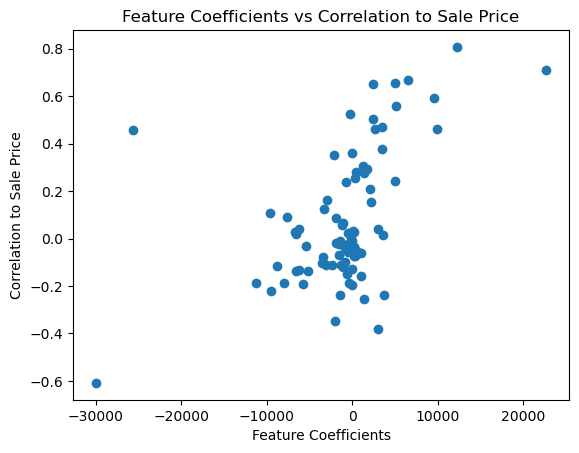

In [62]:
plt.scatter(df_coefs_correls['Coef'], df_coefs_correls['Corr']);
plt.title('Feature Coefficients vs Correlation to Sale Price')
plt.xlabel('Feature Coefficients')
plt.ylabel('Correlation to Sale Price')